In [174]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
import boto3

from dotenv import load_dotenv

In [175]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env


In [176]:
working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Working Directory: /home/lakishadavid/computational_genetic_genealogy
Data Directory: /home/lakishadavid/computational_genetic_genealogy/data
References Directory: /home/lakishadavid/computational_genetic_genealogy/references
Results Directory: /home/lakishadavid/computational_genetic_genealogy/results
Utils Directory: /home/lakishadavid/computational_genetic_genealogy/utils
The current directory is /home/lakishadavid/computational_genetic_genealogy


In [177]:
def configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO"):
    """
    Configure logging for both file and console handlers.

    Args:
        log_filename (str): Path to the log file where logs will be written.
        log_file_debug_level (str): Logging level for the file handler.
        console_debug_level (str): Logging level for the console handler.
    """
    # Create a root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)  # Capture all messages at the root level

    # Convert level names to numeric levels
    file_level = getattr(logging, log_file_debug_level.upper(), logging.INFO)
    console_level = getattr(logging, console_debug_level.upper(), logging.INFO)

    # File handler: Logs messages at file_level and above to the file
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(file_level)
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)

    # Console handler: Logs messages at console_level and above to the console
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(console_level)
    console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(console_formatter)

    # Add handlers to the root logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
def clear_logger():
    """Remove all handlers from the root logger."""
    logger = logging.getLogger()
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)

In [178]:
log_filename = os.path.join(results_directory, "lab5.log")
print(f"The Lab 5 log file is located at {log_filename}.")

# Ensure the results_directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Check if the file exists; if not, create it
if not os.path.exists(log_filename):
    with open(log_filename, 'w') as file:
        pass  # The file is now created.
    
clear_logger() # Clear the logger before reconfiguring it
configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO")

The Lab 5 log file is located at /home/lakishadavid/computational_genetic_genealogy/results/lab5.log.


### Genetic Map

Use your existing Beagle genetic maps to create the genetic maps for IBIS. If you already have these genetic maps, you do not need to rerun these cells to download the genetic maps again.

In [ ]:
def preprocess_ibis_map():
    beagle_map_dir = os.path.join(references_directory, "genetic_maps/beagle_genetic_maps")
    ibis_map_dir = os.path.join(references_directory, "genetic_maps/ibis_genetic_maps")
    os.makedirs(ibis_map_dir, exist_ok=True)
    
    for map_file in os.listdir(beagle_map_dir):
        if map_file.endswith(".map"):
            beagle_map_filename = os.path.join(beagle_map_dir, map_file)
            ibis_map_filename = os.path.join(ibis_map_dir, map_file)
            print(f"Processing {beagle_map_filename} to create IBIS map...")
            
            # For IBIS maps, we need: CHR POSITION GENETIC_POSITION [RATE]
            # From Beagle maps which are: CHR . GENETIC_POSITION PHYSICAL_POSITION
            # Move the genetic position to column 3 (not 4)
            command = f"awk '{{print $1, $4, $3, 0}}' {beagle_map_filename} > {ibis_map_filename}"
            
            subprocess.run(command, shell=True, check=True)
    print("All Beagle genetic maps converted to IBIS format.")

In [ ]:
# Set up output directories
genetic_maps_dir = os.path.join(references_directory, "genetic_maps")
os.makedirs(genetic_maps_dir, exist_ok=True)

ibis_genetic_maps = os.path.join(genetic_maps_dir, "ibis_genetic_maps")
os.makedirs(ibis_genetic_maps, exist_ok=True)

assembly = "GRCh38"
preprocess_ibis_map()

# # Alternative source
# plink2_genetic_map_url="https://alkesgroup.broadinstitute.org/Eagle/downloads/tables/genetic_map_hg38_withX.txt.gz"

**Visual Inspection**

The above code should have created a set of genetic map files in the format that IBIS use. Look in your `references/genetic_mpas` directory and check for the `ibis_genetic_maps` subdirectory and individual by chromosome files within `ibis_genetic_maps`. Open the chromosome 1 file of both `ibis_genetic_maps` and `beagle_genetic_maps`. Compare them, visually. How are they similar? How are they different?

### Concatenate phased VCF files

In [179]:
%%bash -s "$data_directory" "$utils_directory" "$results_directory"

data_directory="$1"
utils_directory="$2"
results_directory="$3"

# Define the directory containing phased VCF files
phased_samples_dir="${results_directory}/phased_samples"

# Concatenate phased VCF files
echo "Creating list of phased VCF files..."
PHASED_FILE_LIST="${phased_samples_dir}/phased_file_list_sample.txt"

# Empty the file list if it already exists
> "$PHASED_FILE_LIST"

for CHR in {1..22}; do
    PHASED_VCF="${phased_samples_dir}/merged_opensnps_phased_chr${CHR}_sorted.vcf.gz"
    if [ -f "$PHASED_VCF" ]; then
        echo "$PHASED_VCF" >> "$PHASED_FILE_LIST"
    else
        echo "Phased VCF missing for chromosome $CHR"
    fi
done

CONCATENATED_VCF="${phased_samples_dir}/merged_opensnps_autosomes.vcf"
SORTED_VCF="${phased_samples_dir}/merged_opensnps_autosomes_sorted.vcf.gz"
STATS_OUTPUT="${phased_samples_dir}/merged_opensnps_autosomes_sorted_stats.vchk"

# Concatenate VCF files
bcftools concat -o "$CONCATENATED_VCF" --file-list "$PHASED_FILE_LIST"

if [ -f "$CONCATENATED_VCF" ]; then
    # Sort and compress the concatenated VCF
    bcftools sort -Oz -o "$SORTED_VCF" "$CONCATENATED_VCF"

    # Index the sorted VCF
    bcftools index --tbi -f "$SORTED_VCF"

    # Generate stats
    bcftools stats -s - "$SORTED_VCF" > "$STATS_OUTPUT"

    echo "Concatenation completed successfully."
else
    echo "Concatenated VCF file missing. Pipeline aborted."
    exit 1
fi

if [ -f "$SORTED_VCF" ] && [ -f "${SORTED_VCF}.tbi" ]; then
    rm "$CONCATENATED_VCF"
fi

Creating list of phased VCF files...


Checking the headers and starting positions of 22 files
Concatenating /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_phased_chr1_sorted.vcf.gz	0.374724 seconds
Concatenating /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_phased_chr2_sorted.vcf.gz	0.065089 seconds
Concatenating /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_phased_chr3_sorted.vcf.gz	0.065437 seconds
Concatenating /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_phased_chr4_sorted.vcf.gz	0.067862 seconds
Concatenating /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_phased_chr5_sorted.vcf.gz	0.087834 seconds
Concatenating /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_phased_chr6_sorted.vcf.gz	0.035278 seconds
Concatenating /home/lakishadavid/computational_genetic_genealo

Concatenation completed successfully.


### Change the format of the data files from VCF to BED.

In [180]:
%%bash -s "$data_directory" "$utils_directory" "$results_directory"

data_directory="$1"
utils_directory="$2"
results_directory="$3"

# Define
phased_samples_dir="${results_directory}/phased_samples"
vcf_file="${phased_samples_dir}/merged_opensnps_autosomes_sorted.vcf.gz"

# Ensure the PLINK2 executable exists
if [[ ! -f "${utils_directory}/plink2" ]]; then
    echo "Error: PLINK2 executable not found: ${utils_directory}/plink2" >&2
    exit 1
fi

# Ensure the phased samples directory exists
if [[ ! -d "${phased_samples_dir}" ]]; then
    echo "Error: Phased samples directory not found: ${phased_samples_dir}" >&2
    exit 1
fi

# Check if the file exists
if [[ ! -f "$vcf_file" ]]; then
    echo "No matching VCF file found in $phased_samples_dir" >&2
    exit 1
fi

# Extract the file prefix (removing .vcf.gz extension)
output_prefix="${vcf_file%.vcf.gz}"

# Convert the VCF file to PLINK format
${utils_directory}/plink2 --vcf "$vcf_file" --autosome --make-bed --out "$output_prefix"

# Check exit status
if [[ $? -eq 0 ]]; then
    echo "PLINK2 successfully processed: ${vcf_file}"
else
    echo "Error processing ${vcf_file}" >&2
fi

PLINK v2.0.0-a.6.4LM 64-bit Intel (6 Dec 2024)     cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.log.
Options in effect:
  --autosome
  --make-bed
  --out /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted
  --vcf /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.vcf.gz

Start time: Sat Feb 22 04:36:48 2025
7789 MiB RAM detected, ~2831 available; reserving 2767 MiB for main workspace.
Using up to 12 threads (change this with --threads).
--vcf: 521956 variants scanned.
--vcf: 458k variants converted. 
/home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted-temporary.pgen
+
/home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merg

Explanation:
- `data_directory`, `utils_directory`, and `results_directory` are passed as arguments and assigned.
- The script verifies that plink2 exists and that the phased_samples_dir is a valid directory.
- It loops over files matching opensnps_phased_*.vcf.gz, checking if they exist before processing.
- Uses PLINK2 to convert each .vcf.gz file to PLINK binary format (.bed, .bim, .fam).
- Handles errors and prints appropriate messages.

### Add Genetic Map to Bim File
(as per the IBIS developer)

In [ ]:
!head -10 /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.bim

In [181]:
%%bash -s "$results_directory" "$references_directory" "$utils_directory"

results_directory="$1"
references_directory="$2"
utils_directory="$3"

python scripts_support/add_genetic_map.py \
  /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.bim \
  /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/ibis_genetic_maps \
  /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.bim.gm

Loading genetic maps...
Loading map file: /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/ibis_genetic_maps/plink.chr1.GRCh38.map
  Loaded 255802 markers for chromosome 1
Loading map file: /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/ibis_genetic_maps/plink.chr10.GRCh38.map
  Loaded 180053 markers for chromosome 10
Loading map file: /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/ibis_genetic_maps/plink.chr11.GRCh38.map
  Loaded 168609 markers for chromosome 11
Loading map file: /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/ibis_genetic_maps/plink.chr12.GRCh38.map
  Loaded 165327 markers for chromosome 12
Loading map file: /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/ibis_genetic_maps/plink.chr13.GRCh38.map
  Loaded 136637 markers for chromosome 13
Loading map file: /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/ibis_

In [ ]:
!head -10 /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.bim.gm

Explanation:
- The script assigns arguments to data_directory, references_directory, and utils_directory.
- It verifies the existence of the add-map-plink.pl script.
- It checks for .bim files in data_directory, ensuring at least one exists.
- Extracts the chromosome number from the .bim filename.
- Determines the corresponding genetic map file.
- If the necessary files exist, it runs the Perl script to append the genetic map.
- The new .bim file is saved with a _gm.bim suffix.
- Errors are handled with messages and exit codes.

### Run the IBD Detection Algorithm

In [182]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"

# Define the IBIS executable path
ibis="${utils_directory}/ibis/ibis"

# Ensure the IBIS executable exists
if [[ ! -f "${ibis}" ]]; then
    echo "Error: IBIS executable not found: ${ibis}" >&2
fi

bed_file="${results_directory}/phased_samples/merged_opensnps_autosomes_sorted.bed"
bim_file="${results_directory}/phased_samples/merged_opensnps_autosomes_sorted.bim.gm"
fam_file="${results_directory}/phased_samples/merged_opensnps_autosomes_sorted.fam"
${ibis} ${bed_file} ${bim_file} ${fam_file} -min_l 7 -mt 500 -er .004 \
    -o "${results_directory}/merged_opensnps_autosomes_ibis" \
    -printCoef -noFamID

# Check exit status
if [[ $? -eq 0 ]]; then
    echo "IBIS analysis completed successfully."
else
    echo "Error running IBIS analysis." >&2
fi

IBIS Segment Caller!  v1.20.9    (Released December 7, 2020)

Viewing arguments...
-min_l - running with minimum IBD1 length 7.000000
-mt - running with minimum IBD1 marker threshold of 499.000000
-er - running with error rate 0.004000
-o - setting output file /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ibis.seg
-printCoef - printing coefficient file
-noFamID - assuming no Family ID in input
No -b or -bfile - Running with input files: /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.bed, /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.bim.gm, /home/lakishadavid/computational_genetic_genealogy/results/phased_samples/merged_opensnps_autosomes_sorted.fam


Parsing SNP file... done.
Parsing individual file... done.
Parsing genotype file... initiated, to complete later.
Defining Windows... done.
Total Genetic Length in use:3540.340332
Organizing genotype data for analysis... done.
Beginning segment detection with 1 thread(s)...Total Segments Found: 31888
done.
IBIS analysis completed successfully.


# IBIS Output File Descriptions

## IBIS
This file contains detailed information about identity-by-descent (IBD) segments shared between pairs of individuals.

### Columns:
- **sample1, sample2**: IDs of the two individuals being compared for shared genetic segments.
- **chrom**: Chromosome number where the IBD segment is located.
- **phys_start_pos, phys_end_pos**: Start and end positions of the IBD segment in base pairs (physical positions).
- **IBD_type**: Type of IBD segment (e.g., IBD1 for sharing one parental haplotype or IBD2 for sharing both parental haplotypes).
- **genetic_start_pos, genetic_end_pos**: Start and end positions of the segment in genetic map units (centiMorgans).
- **genetic_seg_length**: Length of the IBD segment in centiMorgans (genetic distance).
- **marker_count**: Number of genetic markers (SNPs) within the segment.
- **error_count**: Total number of mismatches or genotyping errors detected in the segment.
- **error_density**: Average error rate per marker in the segment (error_count divided by marker_count).

---

## Coef
This file provides information about pairwise kinship coefficients and degrees of relatedness.

### Columns:
- **sample1, sample2**: IDs of the two individuals being compared.
- **kinship_coefficient**: A measure of genetic similarity between the individuals, ranging from 0 (no relation) to higher values for close relatives.
- **IBD2_fraction**: Proportion of the genome where both parental haplotypes are shared between the individuals.
- **segment_count**: Total number of IBD segments identified between the individuals.
- **degree_of_relatedness**: Classification of the relationship based on kinship (e.g., siblings, cousins).

---

## IBD2
Represents segments where two individuals share both parental haplotypes.  
IBD2 is particularly useful in identifying siblings or individuals with close familial ties, as these segments indicate inheritance from both sides of the family.

---

## HBD (Runs of Homozygosity)
Indicates segments where an individual has matching haplotypes on both chromosomes, likely due to inheritance from a common ancestor.  
This is a measure of inbreeding or autozygosity (when an individual inherits identical haplotypes from both parents).

### Columns:
- **sample_id**: ID of the individual being analyzed for HBD segments.
- **chrom**: Chromosome number where the HBD segment is located.
- **phys_start_pos, phys_end_pos**: Start and end positions of the HBD segment in base pairs.
- **HBD_type**: Type or classification of the HBD segment.
- **genetic_start_pos, genetic_end_pos**: Start and end positions of the segment in genetic map units (centiMorgans).
- **genetic_seg_length**: Length of the HBD segment in centiMorgans.
- **marker_count**: Number of genetic markers (SNPs) in the segment.
- **error_count**: Total number of mismatches or genotyping errors detected in the segment.
- **error_density**: Average error rate per marker in the segment.

---

## Incoef
Provides inbreeding coefficients for individuals, based on HBD analysis.

### Columns:
- **sample_id**: ID of the individual being analyzed.
- **inbreeding_coefficient**: A measure of inbreeding for the individual, reflecting the proportion of the genome covered by HBD segments.
- **segment_count**: Total number of HBD segments identified in the individual's genome.

### Explore The Coefficients Results

In [ ]:
def explore_coefficients(
    results_directory, 
    filename="merged_opensnps_autosomes_ibis.coef", 
    focus_on_related=True, 
    save_plots=True, 
    show_plots=True,
    output_subdir="segments"
    ):
    """
    Reads and explores the coefficients file from the results directory.
    Includes handling for missing values and options to focus on related individuals.
    
    Parameters:
        results_directory (str): Directory containing the result files.
        filename (str): Filename of the coefficients file.
        focus_on_related (bool): If True, focuses analysis on related individuals (Degree > 0).
        save_plots (bool): If True, saves plots to the specified output directory.
        output_dir (str): Directory to save plots.
    
    Returns:
        pd.DataFrame: Processed coefficients DataFrame for further analysis.
    """
        
    # Ensure output directory exists
    output_dir = os.path.join(results_directory, output_subdir)
    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Read the coefficients file
    file_path = os.path.join(results_directory, filename)
    coefficients = pd.read_csv(file_path, sep="\t", low_memory=False)

    # Save both full and filtered data if focus_on_related is True
    full_data = coefficients.copy()
    filtered_data = None

    if focus_on_related:
        print("\nFocusing on related individuals (Degree > 0).")
        filtered_data = full_data[full_data['Degree'] > 0]
        print(f"Filtered DataFrame Info (Degree > 0):")
        filtered_data.info()
        print("\n=== Descriptive Statistics (Filtered) ===")
        print(filtered_data.describe())
        print("\n")
        filtered_file_path = os.path.join(output_dir, "filtered_coefficients.csv")
        filtered_data.to_csv(filtered_file_path, index=False)
        print(f"Filtered coefficients saved to: {filtered_file_path}")

    # Save and print the full data
    print("\nFull DataFrame Info:")
    full_data.info()
    print("\n=== Descriptive Statistics (Full) ===")
    print(full_data.describe())
    print("\n")
    full_file_path = os.path.join(output_dir, "full_coefficients.csv")
    full_data.to_csv(full_file_path, index=False)
    print(f"Full coefficients saved to: {full_file_path}")

    # Analyze both datasets
    datasets = {"Full": full_data, "Filtered": filtered_data} if focus_on_related else {"Full": full_data}

    for name, data in datasets.items():
        if data is not None:
            print(f"\n=== Analyzing {name} Data ===")
            
            # Counts by Degree
            degree_grouped_counts = data['Degree'].value_counts().sort_index()
            degree_grouped_counts_df = degree_grouped_counts.reset_index(name='Count')
            degree_grouped_counts_df.columns = ['Degree', 'Count']
            print(f"=== Counts by Degree ({name}) ===")
            print(degree_grouped_counts_df)
            
            # Save HTML table
            html_table = degree_grouped_counts_df.to_html(index=False)
            html_file_path = os.path.join(output_dir, f"{name.lower()}_degree_counts.html")
            with open(html_file_path, "w") as f:
                f.write(html_table)
            print(f"HTML table for {name} data saved to: {html_file_path}")

            # Display in Jupyter if available
            if hasattr(IPython, 'get_ipython') and IPython.get_ipython() is not None:
                display(HTML(html_table))

            # Visualizations
            def save_or_show_plot(fig, filename):
                if save_plots:
                    fig.savefig(os.path.join(output_dir, f"{name.lower()}_{filename}"))
                if show_plots:
                    plt.show()
                plt.close(fig)

            # Degree distribution
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.histplot(data['Degree'], bins=10, kde=False, ax=ax)
            ax.set_title(f'Degree Distribution ({name})')
            ax.set_xlabel('Degree')
            ax.set_ylabel('Frequency')
            save_or_show_plot(fig, "degree_distribution.png")

            # Other plots
            if 'Kinship_Coefficient' in data.columns:
                fig, ax = plt.subplots(figsize=(8, 5))
                sns.histplot(data['Kinship_Coefficient'], bins=30, kde=True, ax=ax)
                ax.set_title(f'Kinship Coefficient Distribution ({name})')
                ax.set_xlabel('Kinship Coefficient')
                ax.set_ylabel('Frequency')
                save_or_show_plot(fig, "kinship_coefficient_distribution.png")

            if 'IBD2_Fraction' in data.columns:
                fig, ax = plt.subplots(figsize=(8, 5))
                sns.histplot(data['IBD2_Fraction'], bins=30, kde=True, ax=ax)
                ax.set_title(f'IBD2 Fraction Distribution ({name})')
                ax.set_xlabel('IBD2 Fraction')
                ax.set_ylabel('Frequency')
                save_or_show_plot(fig, "ibd2_fraction_distribution.png")

            if all(col in data.columns for col in ['Kinship_Coefficient', 'IBD2_Fraction']):
                fig, ax = plt.subplots(figsize=(8, 5))
                sns.scatterplot(
                    data=data,
                    x='Kinship_Coefficient',
                    y='IBD2_Fraction',
                    hue='Degree', palette='viridis', ax=ax
                )
                ax.set_title(f'Kinship vs. IBD2 Fraction ({name})')
                ax.set_xlabel('Kinship Coefficient')
                ax.set_ylabel('IBD2 Fraction')
                plt.legend(title='Degree')
                save_or_show_plot(fig, "kinship_vs_ibd2_fraction.png")

            # Correlation matrix
            numeric_cols = ['Kinship_Coefficient', 'IBD2_Fraction', 'Segment_Count']
            existing_cols = [col for col in numeric_cols if col in data.columns]
            if existing_cols:
                fig, ax = plt.subplots(figsize=(6, 5))
                corr = data[existing_cols].corr()
                sns.heatmap(corr, annot=True, cmap='Blues', square=True, ax=ax)
                ax.set_title(f'Correlation Matrix ({name})')
                save_or_show_plot(fig, "correlation_matrix.png")

    print("\nAnalysis completed.")
    return

In [ ]:
explore_coefficients(
    results_directory, 
    filename="merged_opensnps_autosomes_ibis.coef", 
    focus_on_related=True, 
    save_plots=True,
    show_plots=True,
    output_subdir="segments")

### New Results

Look in your `results/segments` directory. You should see several new files. The image files are the ones that with the `.png` extension. Look at the 5 image files that start wtih `filtered_`. What do you think these mean?

### Explore The Segments Results

In [204]:
seg_file = os.path.join(results_directory, "merged_opensnps_autosomes_ibis.seg")

seg_data_temp = pd.read_csv(seg_file, sep="\t", header=None)
seg_data_temp.columns = [
    "sample1", "sample2", "chrom", 
    "phys_start_pos", "phys_end_pos", 
    "IBD_type", "genetic_start_pos", 
    "genetic_end_pos", "genetic_seg_length", 
    "marker_count", "error_count", "error_density"
    ]
seg_data = seg_data_temp.sort_values(
    by=["chrom", "phys_start_pos", "phys_end_pos", "IBD_type"],
    ascending=[True, True, True, True]
)

output_file = os.path.join(results_directory, "merged_opensnps_autosomes_ibis.csv")
seg_data.to_csv(output_file, sep="\t", index=False, header=False)

Notice the new file extension of `.csv`.

Let's create some data visualizations.

In [205]:
def explore_segments_ibis(
        results_directory, 
        filename="merged_opensnps_autosomes_ibis.csv",
        min_length=7, 
        min_markers=436, 
        max_error_density=0.004,
        save_plots=True,
        show_plots=True, 
        output_subdir="segments"
):
    """
    Explores and optionally filters the segments DataFrame.
    
    Parameters:
        results_directory (str): Directory containing the segments file.
        filename (str): Filename of the segments file.
        min_length (float): Minimum genetic length threshold for filtering.
        min_markers (int): Minimum marker count threshold for filtering.
        max_error_density (float): Maximum error density threshold for filtering.
        filter_segments_enabled (bool): If True, apply filtering to the segments.
        save_plots (bool): If True, save plots to the specified directory.
        output_dir (str): Directory to save outputs and plots.
    
    Returns:
        pd.DataFrame: The segments DataFrame (filtered or unfiltered based on input).
    """
    # Ensure output directory exists
    output_dir = os.path.join(results_directory, output_subdir)
    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Read the segments file
    file_path = os.path.join(results_directory, filename)
    segments = pd.read_csv(file_path, sep="\t", header=None)
    segments.columns = [
        "id1", "id2", "chromosome", "physical_position_start", 
        "physical_position_end", "IBD_type", "genetic_position_start", 
        "genetic_position_end", "genetic_length", "marker_count", 
        "error_count", "error_density"
    ]

    # Ensure numeric columns are properly parsed
    numeric_columns = ["genetic_length", "marker_count", "error_density", "chromosome"]
    for col in numeric_columns:
        if col in segments.columns:
            segments[col] = pd.to_numeric(segments[col], errors='coerce')

    # Drop rows with NaN values in numeric columns
    nan_rows = segments[segments[numeric_columns].isnull().any(axis=1)]
    if not nan_rows.empty:
        nan_file_path = os.path.join(output_dir, "nan_segments_ibis.csv")
        nan_rows.to_csv(nan_file_path, sep="\t", index=False)
        print(f"Rows with NaN values saved to: {nan_file_path}")
    segments = segments.dropna(subset=numeric_columns).reset_index(drop=True)

    # Step 2: Basic info and descriptive statistics
    print("=== Segments DataFrame Info ===")
    segments.info()
    print("\n=== Descriptive Statistics ===")
    print(segments[['genetic_length', 'marker_count', 'error_density']].describe())
    print("\n")

    # Save the unfiltered data
    unfiltered_file_path = os.path.join(output_dir, "unfiltered_segments_ibis.csv")
    segments.to_csv(unfiltered_file_path, sep="\t", index=False)
    print(f"Unfiltered segments saved to: {unfiltered_file_path}")
    print()

    filtered_segments = segments[
        (segments['genetic_length'] >= min_length) &
        (segments['marker_count'] >= min_markers) &
        (segments['error_density'] <= max_error_density)
    ].copy()
    
    print("=== Filtered Segments Info ===")
    filtered_segments.info()
    print("\n=== Descriptive Statistics (Filtered) ===")
    print(filtered_segments[['genetic_length', 'marker_count', 'error_density']].describe())
    print("\n")
    
    # Save filtered segments to a new file
    filtered_filename = "filtered_segments_ibis.csv"
    filtered_file_path = os.path.join(output_dir, filtered_filename)
    filtered_segments.to_csv(filtered_file_path, sep="\t", index=False)
    print(f"Filtered segments saved to: {filtered_file_path}")

    print(f"\nSummary:")
    print(f"Total segments: {len(segments)}")
    print(f"Filtered segments: {len(filtered_segments)}")
    if not nan_rows.empty:
        print(f"Rows with NaN values: {len(nan_rows)} (saved to: {nan_file_path})")


    # Step 4: Visualizations
    def save_or_show_plot(fig, filename):
        if save_plots:
            fig.savefig(os.path.join(output_dir, filename))
        if show_plots:
            plt.show()
        plt.close(fig)

    def plot_distribution(data, column, title, xlabel, ylabel, filename, bins=30, kde=True):
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.histplot(data[column], bins=bins, kde=kde, ax=ax)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        save_or_show_plot(fig, filename)

    # Visualize genetic_length distribution
    plot_distribution(
        segments, "genetic_length", "Distribution of Genetic Length", 
        "Genetic Length (cM)", "Frequency", "genetic_length_distribution_unfiltered.png"
    )

    plot_distribution(
        filtered_segments, "genetic_length", "Distribution of Genetic Length (Filtered)", 
        "Genetic Length (cM)", "Frequency", "genetic_length_distribution_filtered.png"
    )

    # Visualize marker_count distribution
    plot_distribution(
        segments, "marker_count", "Distribution of Marker Count", 
        "Marker Count", "Frequency", "marker_count_distribution_unfiltered.png"
    )
    plot_distribution(
        filtered_segments, "marker_count", "Distribution of Marker Count (Filtered)", 
        "Marker Count", "Frequency", "marker_count_distribution_filtered.png"
    )

    # Boxplot of genetic_length by chromosome
    def plot_boxplot(data, x_col, y_col, title, xlabel, ylabel, filename):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(x=x_col, y=y_col, data=data, ax=ax)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.xticks(rotation=45)
        plt.tight_layout()
        save_or_show_plot(fig, filename)

    plot_boxplot(
        segments, "chromosome", "genetic_length", 
        "Distribution of Genetic Length by Chromosome", 
        "Chromosome", "Genetic Length (cM)", "genetic_length_by_chromosome_unfiltered.png"
    )
    plot_boxplot(
        filtered_segments, "chromosome", "genetic_length", 
        "Distribution of Genetic Length by Chromosome (Filtered)", 
        "Chromosome", "Genetic Length (cM)", "genetic_length_by_chromosome_filtered.png"
    )

    print("\nAnalysis completed.")
    return

=== Segments DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31888 entries, 0 to 31887
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id1                      31888 non-null  object 
 1   id2                      31888 non-null  object 
 2   chromosome               31888 non-null  int64  
 3   physical_position_start  31888 non-null  int64  
 4   physical_position_end    31888 non-null  int64  
 5   IBD_type                 31888 non-null  object 
 6   genetic_position_start   31888 non-null  float64
 7   genetic_position_end     31888 non-null  float64
 8   genetic_length           31888 non-null  float64
 9   marker_count             31888 non-null  int64  
 10  error_count              31888 non-null  int64  
 11  error_density            31888 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.9+ MB

=== Descriptive Statistics ===
       ge

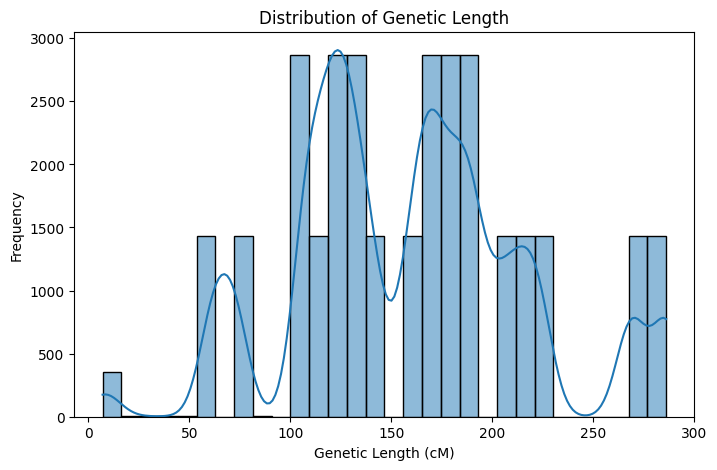

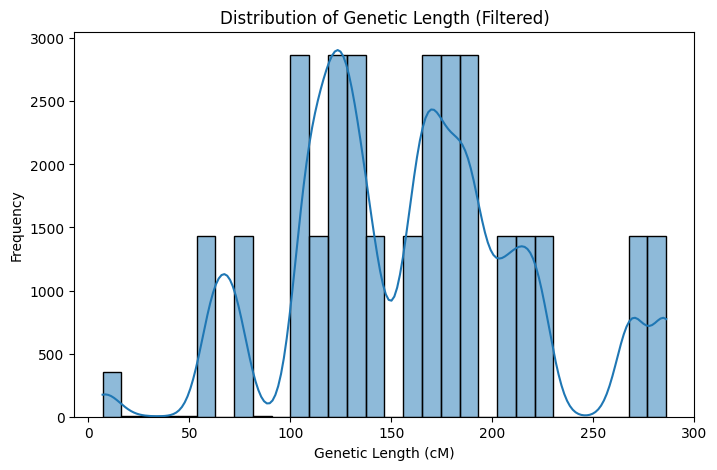

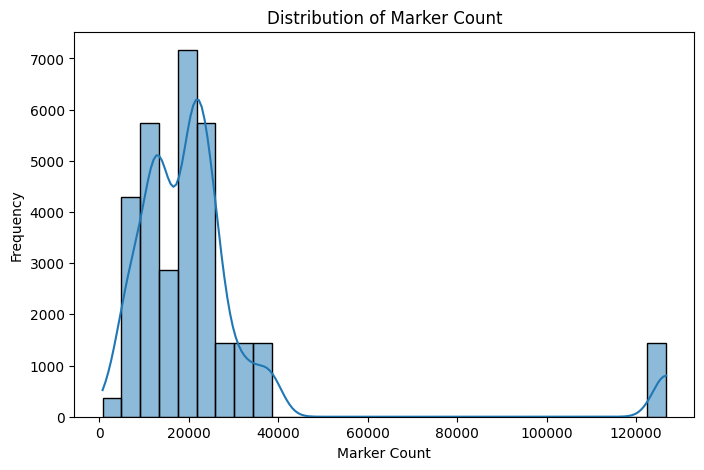

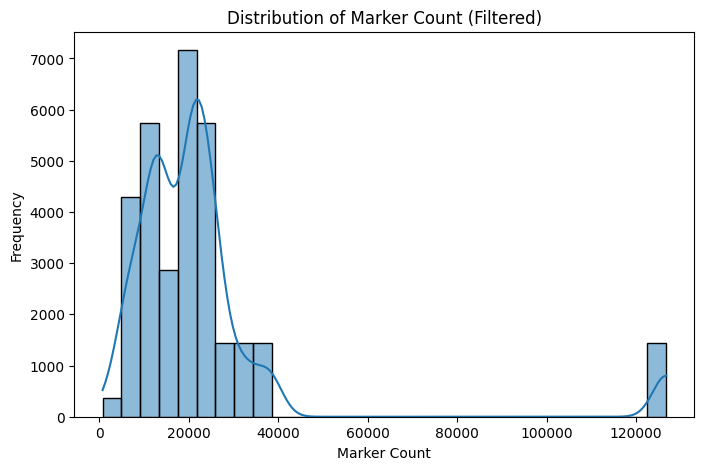

2025-02-22 04:44:31,278 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-22 04:44:31,293 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


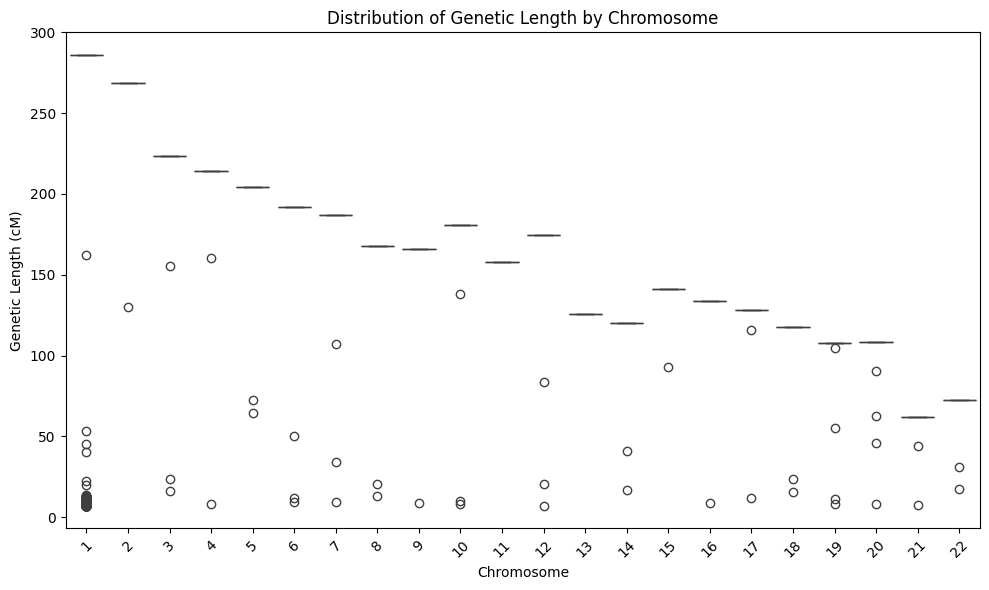

2025-02-22 04:44:31,521 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-22 04:44:31,539 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


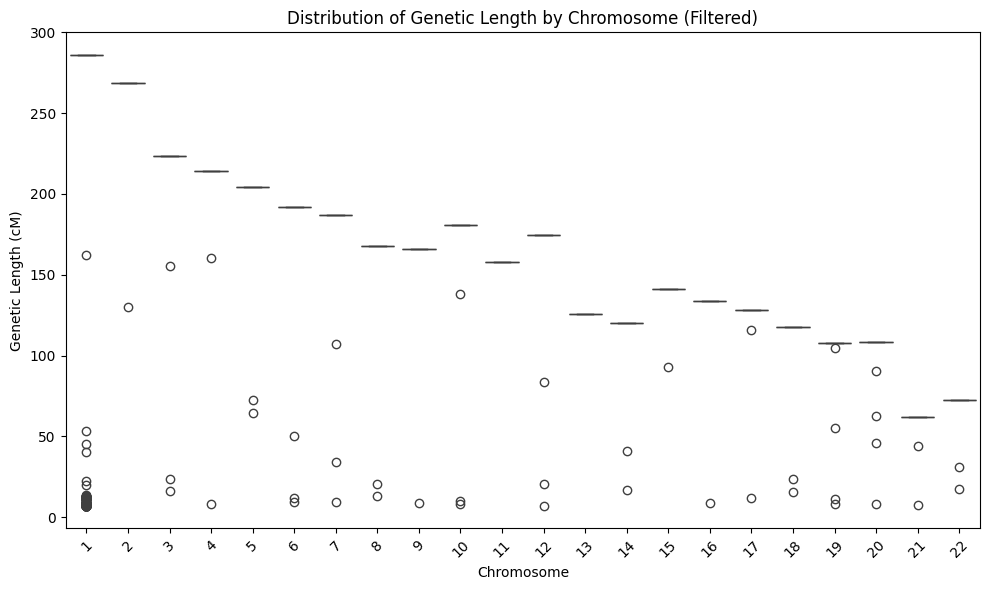


Analysis completed.


In [206]:
explore_segments_ibis(
        results_directory, 
        filename="merged_opensnps_autosomes_ibis.csv",
        min_length=7, 
        min_markers=436, 
        max_error_density=0.004,
        save_plots=True,
        show_plots=True,
        output_subdir="segments"
)

The plots were saved in your `results/segments` directory.

Take a look at the plots. What information are they communicating? Some are meaningful. Some less so. What other information do you think should be communicated?

### Continue to explore the segment data.

The following cell takes the segment data output from IBIS IBD dectection algorithm and processes it using `pandas`.

In [207]:
file_path = os.path.join(results_directory, "merged_opensnps_autosomes_ibis.csv")
segments = pd.read_csv(file_path, sep="\t", header=None)
segments.columns = [
    "id1", "id2", "chromosome", "physical_position_start", 
    "physical_position_end", "IBD_type", "genetic_position_start", 
    "genetic_position_end", "genetic_length", "marker_count", 
    "error_count", "error_density"
]

# Ensure numeric columns are properly parsed
numeric_columns = ["genetic_length", "marker_count", "error_density", "chromosome"]
for col in numeric_columns:
    if col in segments.columns:
        segments[col] = pd.to_numeric(segments[col], errors='coerce')

segments = segments.dropna(subset=numeric_columns).reset_index(drop=True)

The next cell allows you to look at the first five rows. Notice that the data now has column headers. The IBIS output file does not come with column headers. We have to look at the developers' GitHub page or other documenation to determine the names of the columns.

In [208]:
segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31888 entries, 0 to 31887
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id1                      31888 non-null  object 
 1   id2                      31888 non-null  object 
 2   chromosome               31888 non-null  int64  
 3   physical_position_start  31888 non-null  int64  
 4   physical_position_end    31888 non-null  int64  
 5   IBD_type                 31888 non-null  object 
 6   genetic_position_start   31888 non-null  float64
 7   genetic_position_end     31888 non-null  float64
 8   genetic_length           31888 non-null  float64
 9   marker_count             31888 non-null  int64  
 10  error_count              31888 non-null  int64  
 11  error_density            31888 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.9+ MB


In [210]:
segments.head() # You can enter a number greater than 5 to view more rows

,id1,id2,chromosome,physical_position_start,physical_position_end,IBD_type,genetic_position_start,genetic_position_end,genetic_length,marker_count,error_count,error_density
0,user1691,user1693,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
1,user1691,user1715,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
2,user1691,user1731,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
3,user1691,user1732,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
4,user1691,user1737,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000


In [211]:
segments.loc[(segments["id1"] == "user1691") & (segments["id2"] == "user1693")]

,id1,id2,chromosome,physical_position_start,physical_position_end,IBD_type,genetic_position_start,genetic_position_end,genetic_length,marker_count,error_count,error_density
0,user1691,user1693,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
1775,user1691,user1693,2,27572,242078572,IBD1,0.010219,268.829468,268.819244,32031,0,0.000000
3209,user1691,user1693,3,19817,198106887,IBD1,0.001031,223.254700,223.253662,26840,0,0.000000
4643,user1691,user1693,4,71674,189994495,IBD1,0.341277,214.545837,214.204559,23558,0,0.000000
6077,user1691,user1693,5,38141,181263936,IBD1,0.038418,204.085632,204.047211,24623,0,0.000000
7512,user1691,user1693,6,203878,170610382,IBD1,0.353001,192.033142,191.680145,25666,0,0.000000
8947,user1691,user1693,7,44935,159278280,IBD1,0.006018,187.146729,187.140717,21865,0,0.000000
10381,user1691,user1693,8,232340,145067348,IBD1,0.006315,168.000717,167.994400,21682,0,0.000000
11816,user1691,user1693,9,46587,138117319,IBD1,0.029974,166.284775,166.254807,19466,0,0.000000
13249,user1691,user1693,10,89716,133620799,IBD1,0.009865,180.915131,180.905258,21702,0,0.000000


In [189]:
segments[["genetic_length", "marker_count", "error_count", "error_density"]].describe()

,genetic_length,marker_count,error_count,error_density
count,31888.000000,31888.000000,31888.000000,31888.000000
mean,159.131341,23460.931291,0.018345,0.000013
std,57.785609,23793.115085,0.222476,0.000150
min,7.000717,704.000000,0.000000,0.000000
25%,120.198967,12751.000000,0.000000,0.000000
50%,158.201447,19954.000000,0.000000,0.000000
75%,191.680145,24623.000000,0.000000,0.000000
max,286.133575,126776.000000,7.000000,0.003551


In [190]:
# filter segments on min_length=7, min_markers=436, max_error_density=0.004,

filtered_segments = segments[
    (segments["genetic_length"] >= 7) & 
    (segments["marker_count"] >= 436) & 
    (segments["error_density"] <= 0.004)
].copy()

filtered_segments[["genetic_length", "marker_count", "error_count", "error_density"]].describe()

,genetic_length,marker_count,error_count,error_density
count,31888.000000,31888.000000,31888.000000,31888.000000
mean,159.131341,23460.931291,0.018345,0.000013
std,57.785609,23793.115085,0.222476,0.000150
min,7.000717,704.000000,0.000000,0.000000
25%,120.198967,12751.000000,0.000000,0.000000
50%,158.201447,19954.000000,0.000000,0.000000
75%,191.680145,24623.000000,0.000000,0.000000
max,286.133575,126776.000000,7.000000,0.003551


In [191]:
filtered_segments_20cM = filtered_segments[filtered_segments["genetic_length"] >= 20].copy()
filtered_segments_20cM[["genetic_length", "marker_count", "error_count", "error_density"]].describe()

,genetic_length,marker_count,error_count,error_density
count,31530.000000,31530.000000,31530.000000,31530.000000
mean,160.843413,23712.855852,0.001744,0.000000
std,55.820659,23809.306481,0.066375,0.000004
min,20.167221,1637.000000,0.000000,0.000000
25%,120.198967,12751.000000,0.000000,0.000000
50%,158.201447,19954.000000,0.000000,0.000000
75%,191.680145,24623.000000,0.000000,0.000000
max,286.133575,126776.000000,5.000000,0.000299


Let's aggregate the data by pairs instead of looking at it by segment.

In [192]:
import pandas as pd
import numpy as np

# First ensure id1 and id2 are consistently ordered
filtered_segments[["id1", "id2"]] = filtered_segments.apply(
    lambda row: pd.Series((row["id1"], row["id2"])) if row["id1"] < row["id2"] 
    else pd.Series((row["id2"], row["id1"])), axis=1
)

filtered_segments.head()

,id1,id2,chromosome,physical_position_start,physical_position_end,IBD_type,genetic_position_start,genetic_position_end,genetic_length,marker_count,error_count,error_density
0,user1691,user1693,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
1,user1691,user1715,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
2,user1691,user1731,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
3,user1691,user1732,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000
4,user1691,user1737,1,115746,248918526,IBD1,0.140817,286.274384,286.133575,126776,0,0.000000


In [193]:
pair_counts = filtered_segments.groupby(["id1", "id2"]).size().reset_index(name="pair_count")
pair_count_distribution = pair_counts["pair_count"].value_counts().reset_index()
pair_count_distribution.columns = ["Number of Segments", "Number of Pairs"]
pair_count_distribution = pair_count_distribution.reset_index(drop=True)
display(pair_count_distribution.style.hide(axis="index"))

Number of Segments,Number of Pairs
22,1431
1,348
2,2
24,1
27,1
3,1


In [194]:
filtered_segments[filtered_segments["IBD_type"] == "IBD1"].shape[0]

31888

In [195]:
filtered_segments[filtered_segments["IBD_type"] == "IBD2"].shape[0]

0

In [196]:
filtered_segments[filtered_segments["id1"] == filtered_segments["id2"]].shape[0]

0

In [197]:
# Group by id pairs and calculate all metrics at once
aggregated_segments = filtered_segments.groupby(["id1", "id2"]).agg(
    total_genetic_length=("genetic_length", "sum"),
    num_segments=("genetic_length", "count"),
    largest_segment=("genetic_length", "max")
).reset_index()

# Check distribution of values
print(aggregated_segments.describe())

       total_genetic_length  num_segments  largest_segment
count           1784.000000   1784.000000      1784.000000
mean            2844.383517     17.874439       231.403357
std             1404.638314      8.349283       110.464102
min                7.000717      1.000000         7.000717
25%             3540.340140     22.000000       286.133575
50%             3540.340140     22.000000       286.133575
75%             3540.340140     22.000000       286.133575
max             3540.340140     27.000000       286.133575


In [198]:
aggregated_segments_by_type = filtered_segments.groupby(
    ["id1", "id2", "IBD_type"]
).agg(
    total_genetic_length=("genetic_length", "sum"),
    num_segments=("genetic_length", "count"),
    largest_segment=("genetic_length", "max")
).reset_index()

pd.options.display.float_format = '{:.6f}'.format
# Display the result
ibd1_summary = aggregated_segments_by_type[aggregated_segments_by_type["IBD_type"] == "IBD1"].describe()
display(ibd1_summary)

ibd2_summary = aggregated_segments_by_type[aggregated_segments_by_type["IBD_type"] == "IBD2"].describe()
display(ibd2_summary)

,total_genetic_length,num_segments,largest_segment
count,1784.000000,1784.000000,1784.000000
mean,2844.383517,17.874439,231.403357
std,1404.638314,8.349283,110.464102
min,7.000717,1.000000,7.000717
25%,3540.340140,22.000000,286.133575
50%,3540.340140,22.000000,286.133575
75%,3540.340140,22.000000,286.133575
max,3540.340140,27.000000,286.133575


,total_genetic_length,num_segments,largest_segment
count,0.000000,0.000000,0.000000
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [200]:
aggregated_segments[["total_genetic_length", "num_segments", "largest_segment"]].describe()

,total_genetic_length,num_segments,largest_segment
count,1784.000000,1784.000000,1784.000000
mean,2844.383517,17.874439,231.403357
std,1404.638314,8.349283,110.464102
min,7.000717,1.000000,7.000717
25%,3540.340140,22.000000,286.133575
50%,3540.340140,22.000000,286.133575
75%,3540.340140,22.000000,286.133575
max,3540.340140,27.000000,286.133575


In [ ]:
# Filter the pairs that meet the criteria
filtered_pairs1 = aggregated_segments[aggregated_segments["total_genetic_length"] >= 3000]

display(filtered_pairs1[["id1", "id2", "total_genetic_length"]])

In [ ]:
# Filter the pairs that meet the criteria
filtered_pairs2 = aggregated_segments[aggregated_segments["total_genetic_length"] >= 1000]

display(filtered_pairs2[["id1", "id2", "total_genetic_length"]])

In [ ]:
display(aggregated_segments)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define columns to plot
columns = ["total_genetic_length", "num_segments", "largest_segment"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for each metric
for i, col in enumerate(columns):
    sns.histplot(aggregated_segments[col], bins=30, kde=True, ax=axes[i], edgecolor="black")
    axes[i].set_title(f"Distribution of {col.replace('_', ' ').title()}")
    axes[i].set_xlabel(col.replace('_', ' ').title())
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Box Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(columns):
    sns.boxplot(y=aggregated_segments[col], ax=axes[i])
    axes[i].set_title(f"Box Plot of {col.replace('_', ' ').title()}")
    axes[i].set_ylabel(col.replace('_', ' ').title())

plt.tight_layout()
plt.show()
